In [29]:
import os,sys
from pathlib import Path
currentdir = Path(os.getcwd())
sys.path.insert(0, os.path.dirname(currentdir.parent))
sys.path.insert(0, os.path.dirname(currentdir))
print(str(sys.path[0:3]))

['d:\\BAMT', 'd:\\', 'd:\\BAMT']


In [30]:
import bamt.networks as Nets
import bamt.preprocessors as pp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from bamt.Builders import StructureBuilder

from pgmpy.estimators import K2Score
from gmr import GMM
import seaborn as sns

In [31]:
data = pd.read_csv(r'../Data/real data/hack_processed_with_rf.csv')
data

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/offshore,...,Period,Lithology,Gross,Netpay,Porosity,Permeability,Oil density,Oil recovery factor,Condensate recovery factor,Gas recovery factor
0,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,...,JURASSIC,LIMESTONE,75.0,55.2,21.0,410.0,839.762611,NaN,NaN,NaN
1,ABU GHARADIG,BAHARIYA,EGYPT,AFRICA,ABU GHARADIG,EXTENSION,29.7422,28.4925,GUPCO,ONSHORE,...,CRETACEOUS,SANDSTONE,223.5,43.2,10.0,8.0,NaN,NaN,NaN,0.84
2,ABU MADI-EL QARA,ABU MADI (LEVEL II),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,...,NEOGENE,THINLY-BEDDED SANDSTONE,34.5,19.8,22.0,200.0,NaN,NaN,NaN,0.75
3,ABU MADI-EL QARA,ABU MADI (LEVEL III),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,...,NEOGENE,SANDSTONE,152.7,123.0,20.0,300.0,779.614325,NaN,NaN,0.78
4,AL HUWAISAH,SHUAIBA,OMAN,MIDDLE EAST,FAHUD SALT,COMPRESSION,21.9607,56.0452,PDO,ONSHORE,...,CRETACEOUS,LIMESTONE,75.0,30.0,21.0,60.0,825.072886,0.26,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,ZAOYUAN,KONGDIAN-1 (ZILAITUN BLOCK),CHINA,FAR EAST,BOHAI,EXTENSION,38.2100,117.0600,PETROCHINA,ONSHORE,...,PALEOGENE,SANDSTONE,49.2,18.6,23.2,121.0,946.488294,0.13,NaN,NaN
510,ZAOYUAN,KONGDIAN-2 (FENGHUADIAN BLOCK),CHINA,FAR EAST,BOHAI,NaN,38.2100,117.0600,PETROCHINA,ONSHORE,...,PALEOGENE,SANDSTONE,88.5,23.7,NaN,60.0,881.619938,0.19,NaN,NaN
511,ZAOYUAN,UNNAMED (FENGHUADIAN BLOCK),CHINA,FAR EAST,BOHAI,EXTENSION,38.2100,117.0600,PETROCHINA,ONSHORE,...,MESOZOIC,VOLCANICS,147.6,58.2,12.7,3.6,870.769231,0.05,NaN,NaN
512,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,...,CARBONIFEROUS,SANDSTONE,78.6,9.9,24.0,30.0,887.147335,0.24,NaN,NaN


In [32]:
cols = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity','Permeability', 'Depth']
data = data[cols]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [33]:
data.head(10)

,Tectonic regime,Period,Lithology,Structural setting,Gross,Netpay,Porosity,Permeability,Depth
0,COMPRESSION,JURASSIC,LIMESTONE,FORELAND,75.0,55.2,21.0,410.0,1815.0
1,EXTENSION,CRETACEOUS,SANDSTONE,RIFT,223.5,43.2,10.0,8.0,3084.6
2,STRIKE-SLIP,NEOGENE,THINLY-BEDDED SANDSTONE,WRENCH,34.5,19.8,22.0,200.0,2952.9
3,STRIKE-SLIP,NEOGENE,SANDSTONE,WRENCH,152.7,123.0,20.0,300.0,3149.7
4,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,75.0,30.0,21.0,60.0,1486.5
5,GRAVITY,CRETACEOUS,LIMESTONE,PASSIVE MARGIN,28.5,4.5,12.0,20.0,2610.0
6,COMPRESSION,CARBONIFEROUS,LIMESTONE,SUB-SALT,90.0,31.5,10.0,20.0,1800.0
7,COMPRESSION,CARBONIFEROUS,LIMESTONE,SUB-SALT,182.1,32.4,10.0,20.0,2874.0
8,COMPRESSION,JURASSIC,SANDSTONE,FORELAND,15.0,14.7,20.0,15.0,1980.0
9,COMPRESSION,PALEOGENE,SANDSTONE,FORELAND,2400.0,172.5,5.0,0.1,4575.0


In [34]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(data)

In [35]:
bn = Nets.HybridBN(has_logit=False, use_mixture=True) # init BN
info = p.info
info

{'types': {'Tectonic regime': 'disc',
  'Period': 'disc',
  'Lithology': 'disc',
  'Structural setting': 'disc',
  'Gross': 'cont',
  'Netpay': 'cont',
  'Porosity': 'cont',
  'Permeability': 'cont',
  'Depth': 'cont'},
 'signs': {'Gross': 'pos',
  'Netpay': 'pos',
  'Porosity': 'pos',
  'Permeability': 'pos',
  'Depth': 'pos'}}

In [36]:
bn.add_nodes(info)

In [37]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Period,Discrete,disc,[],[]
2,Lithology,Discrete,disc,[],[]
3,Structural setting,Discrete,disc,[],[]
4,Gross,Gaussian,cont,[],[]
5,Netpay,Gaussian,cont,[],[]
6,Porosity,Gaussian,cont,[],[]
7,Permeability,Gaussian,cont,[],[]
8,Depth,Gaussian,cont,[],[]


In [38]:
bn.add_edges(discretized_data,  scoring_function=('K2',K2Score))

  0%|          | 11/1000000 [00:00<13:37:32, 20.39it/s]


In [39]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,Tectonic regime,Discrete,disc,[],[]
1,Lithology,Discrete,disc,[],[]
2,Structural setting,Discrete,disc,[Tectonic regime],[disc]
3,Period,Discrete,disc,[Structural setting],[disc]
4,Porosity,ConditionalMixtureGaussian,cont,[Period],[disc]
5,Gross,ConditionalMixtureGaussian,cont,"[Period, Lithology, Structural setting]","[disc, disc, disc]"
6,Permeability,ConditionalMixtureGaussian,cont,"[Porosity, Lithology]","[cont, disc]"
7,Depth,ConditionalMixtureGaussian,cont,"[Porosity, Structural setting]","[cont, disc]"
8,Netpay,MixtureGaussian,cont,[Gross],[cont]


In [40]:
bn.fit_parameters(data)

In [41]:
test = data[['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay', 'Porosity','Permeability']]

In [42]:
val_pred = bn.predict(test, 5)

100%|██████████| 442/442 [00:00<00:00, 1037.95it/s]


In [44]:
mean_squared_error(data['Depth'].values, val_pred['Depth'], squared=False)

767.2130747396973

In [50]:
sample = bn.sample(5000)

100%|██████████| 5000/5000 [00:22<00:00, 218.34it/s]


In [51]:
sample = bn.sample(5000, parall_count=5)

100%|██████████| 5000/5000 [00:05<00:00, 901.04it/s]


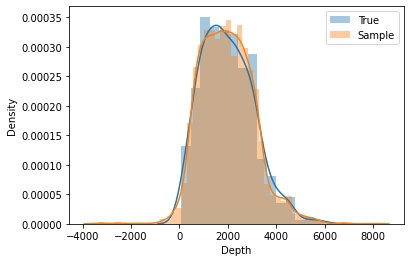

In [52]:
sns.distplot(data['Depth'], label='True')
sns.distplot(sample['Depth'], label='Sample')
plt.legend()